# **Fake News Detection on UPFD dataset**

# Setup


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install torch geometric
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git

import torch_geometric
torch_geometric.__version__

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  Preparing metadata (setup.py) ... done


'2.5.1'

In [4]:
import argparse
import os.path as osp
import numpy as np
from math import ceil
import pandas as pd
import copy
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool, DenseSAGEConv
from torch_geometric.transforms import ToUndirected
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from torch_geometric.nn import global_mean_pool as gmp

import torch.nn.functional as F
from torch_geometric.data import DenseDataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
from tqdm import tqdm


# Load Data

In [5]:
import os
import os.path as osp
import torch
from typing import Callable, List, Optional

import numpy as np
import scipy.sparse as sp
import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from torch_geometric.io import read_txt_array
from torch_geometric.utils import coalesce, cumsum


class UPFD(InMemoryDataset):
    url = 'https://drive.usercontent.google.com/download?id={}&export=download&authuser=5&confirm=t'

    ids = {
        'politifact': '1KOmSrlGcC50PjkvRVbyb_WoWHVql06J-',
        'gossipcop': '10bEhVUnJQqsYI9-D9tmSMDHmjBki8lcX',
    }

    def __init__(
        self,
        root: str,
        name: str,
        feature: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
    ) -> None:
        self.root = root
        self.name = name
        self.feature = feature
        super().__init__(root, transform, pre_transform, pre_filter)

        assert split in ['train', 'val', 'test']
        path = self.processed_paths[['train', 'val', 'test'].index(split)]
        self.load(path)

    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name, 'processed', self.feature)

    @property
    def raw_file_names(self) -> List[str]:
        return [
            'node_graph_id.npy', 'graph_labels.npy', 'A.txt', 'train_idx.npy',
            'val_idx.npy', 'test_idx.npy', f'new_{self.feature}_feature.npz'
        ]

    @property
    def processed_file_names(self) -> List[str]:
        return ['train.pt', 'val.pt', 'test.pt']

    def download(self) -> None:
        path = download_url(self.url.format(self.ids[self.name]),self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self) -> None:
        x = sp.load_npz(
            osp.join(self.raw_dir, f'new_{self.feature}_feature.npz'))
        x = torch.from_numpy(x.todense()).to(torch.float)

        edge_index = read_txt_array(osp.join(self.raw_dir, 'A.txt'), sep=',',
                                    dtype=torch.long).t()
        edge_index = coalesce(edge_index, num_nodes=x.size(0))

        y = np.load(osp.join(self.raw_dir, 'graph_labels.npy'))
        y = torch.from_numpy(y).to(torch.long)
        _, y = y.unique(sorted=True, return_inverse=True)

        batch = np.load(osp.join(self.raw_dir, 'node_graph_id.npy'))
        batch = torch.from_numpy(batch).to(torch.long)

        node_slice = cumsum(batch.bincount())
        edge_slice = cumsum(batch[edge_index[0]].bincount())
        graph_slice = torch.arange(y.size(0) + 1)
        self.slices = {
            'x': node_slice,
            'edge_index': edge_slice,
            'y': graph_slice
        }

        edge_index -= node_slice[batch[edge_index[0]]].view(1, -1)
        self.data = Data(x=x, edge_index=edge_index, y=y)

        for path, split in zip(self.processed_paths, ['train', 'val', 'test']):
            idx = np.load(osp.join(self.raw_dir, f'{split}_idx.npy')).tolist()
            data_list = [self.get(i) for i in idx]
            if self.pre_filter is not None:
                data_list = [d for d in data_list if self.pre_filter(d)]
            if self.pre_transform is not None:
                data_list = [self.pre_transform(d) for d in data_list]
            self.save(data_list, path)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, name={self.name}, '
                f'feature={self.feature})')

In [6]:
def load_data(split):
  data_profile =  UPFD('/content/drive/MyDrive', "politifact", "profile", split, ToUndirected())
  data_bert =  UPFD('/content/drive/MyDrive', "politifact", "bert", split, ToUndirected())
  data_profile.data.x = torch.cat((data_profile.data.x, data_bert.data.x),dim =1)

  return data_profile

In [7]:
# Retrieve data
train_data = load_data('train')
test_data = load_data('test')
val_data = load_data('val')

# Prepare data loader for GNN
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


# **Bi_GCN**

In [8]:
!pip install utils

In [9]:
!pip install keras
!pip install scikit-learn
!pip install tqdm
!pip install numpy
!pip install scipy

In [10]:
import os
import sys
sys.path.append(os.getcwd())
import argparse
from tqdm import tqdm
import copy as cp

import torch
from torch.utils.data import random_split
from torch_scatter import scatter_mean
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, DataListLoader
from torch_geometric.nn import DataParallel


import sys
sys.path.append('/content/drive/MyDrive/')
from data_loader import *
from eval_helper import *

In [11]:
import os
import sys
sys.path.append(os.getcwd())
import argparse
from tqdm import tqdm
import copy as cp

import torch
from torch.utils.data import random_split
from torch_scatter import scatter_mean
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, DataListLoader
from torch_geometric.nn import DataParallel


class TDrumorGCN(torch.nn.Module):
	def __init__(self, in_feats, hid_feats, out_feats):
		super(TDrumorGCN, self).__init__()
		self.conv1 = GCNConv(in_feats, hid_feats)
		self.conv2 = GCNConv(hid_feats+in_feats, out_feats)

	def forward(self, data):
		x, edge_index = data.x, data.edge_index
		x1 = cp.copy(x.float())
		x = self.conv1(x, edge_index)
		x2 = cp.copy(x)
		rootindex = data.root_index
		root_extend = torch.zeros(len(data.batch), x1.size(1)).to(rootindex.device)
		batch_size = max(data.batch) + 1

		for num_batch in range(batch_size):
			index = (torch.eq(data.batch, num_batch))
			root_extend[index] = x1[rootindex[num_batch]]
		x = torch.cat((x, root_extend), 1)

		x = F.relu(x)
		x = F.dropout(x, training=self.training)
		x = self.conv2(x, edge_index)
		x = F.relu(x)
		root_extend = torch.zeros(len(data.batch), x2.size(1)).to(rootindex.device)
		for num_batch in range(batch_size):
			index = (torch.eq(data.batch, num_batch))
			root_extend[index] = x2[rootindex[num_batch]]
		x = torch.cat((x, root_extend), 1)
		x = scatter_mean(x, data.batch, dim=0)

		return x


class BUrumorGCN(torch.nn.Module):
	def __init__(self, in_feats, hid_feats, out_feats):
		super(BUrumorGCN, self).__init__()
		self.conv1 = GCNConv(in_feats, hid_feats)
		self.conv2 = GCNConv(hid_feats+in_feats, out_feats)

	def forward(self, data):
		x, edge_index = data.x, data.BU_edge_index
		x1 = cp.copy(x.float())
		x = self.conv1(x, edge_index)
		x2 = cp.copy(x)

		rootindex = data.root_index
		root_extend = torch.zeros(len(data.batch), x1.size(1)).to(rootindex.device)
		batch_size = max(data.batch) + 1
		for num_batch in range(batch_size):
			index = (torch.eq(data.batch, num_batch))
			root_extend[index] = x1[rootindex[num_batch]]
		x = torch.cat((x, root_extend), 1)

		x = F.relu(x)
		x = F.dropout(x, training=self.training)
		x = self.conv2(x, edge_index)
		x = F.relu(x)
		root_extend = torch.zeros(len(data.batch), x2.size(1)).to(rootindex.device)
		for num_batch in range(batch_size):
			index = (torch.eq(data.batch, num_batch))
			root_extend[index] = x2[rootindex[num_batch]]
		x = torch.cat((x, root_extend), 1)

		x = scatter_mean(x, data.batch, dim=0)
		return x


class Net(torch.nn.Module):
	def __init__(self, in_feats, hid_feats, out_feats):
		super(Net, self).__init__()
		self.TDrumorGCN = TDrumorGCN(in_feats, hid_feats, out_feats)
		self.BUrumorGCN = BUrumorGCN(in_feats, hid_feats, out_feats)
		self.fc = torch.nn.Linear((out_feats+hid_feats) * 2, 2)

	def forward(self, data):
		TD_x = self.TDrumorGCN(data)
		BU_x = self.BUrumorGCN(data)
		x = torch.cat((TD_x, BU_x), 1)
		x = self.fc(x)
		x = F.log_softmax(x, dim=1)
		return x


def compute_test(loader, verbose=False):
	model.eval()
	loss_test = 0.0
	out_log = []
	with torch.no_grad():
		for data in loader:
			if not args.multi_gpu:
				data = data.to(args.device)
			out = model(data)
			if args.multi_gpu:
				y = torch.cat([d.y for d in data]).to(out.device)
			else:
				y = data.y
			if verbose:
				print(F.softmax(out, dim=1).cpu().numpy())
			out_log.append([F.softmax(out, dim=1), y])
			loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader), loss_test

## **Bi_GCN Model Performance**

In [12]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')
# hyper-parameters
parser.add_argument('--dataset', type=str, default='gossipcop', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--TDdroprate', type=float, default=0.2, help='dropout ratio')
parser.add_argument('--BUdroprate', type=float, default=0.2, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=35, help='maximum number of epochs')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='bert', help='feature type, [profile, spacy, bert, content]')

# args = parser.parse_args()
args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature=args.feature, empty=False, name=args.dataset,
					 transform=DropEdge(args.TDdroprate, args.BUdroprate))

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features


num_training = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

if args.multi_gpu:
	loader = DataListLoader
else:
	loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set, batch_size=args.batch_size, shuffle=False)

model = Net(args.num_features, args.nhid, args.nhid)
if args.multi_gpu:
	model = DataParallel(model)
model = model.to(args.device)

if not args.multi_gpu:
	BU_params = list(map(id, model.BUrumorGCN.conv1.parameters()))
	BU_params += list(map(id, model.BUrumorGCN.conv2.parameters()))
	base_params = filter(lambda p: id(p) not in BU_params, model.parameters())
	optimizer = torch.optim.Adam([
		{'params': base_params},
		{'params': model.BUrumorGCN.conv1.parameters(), 'lr': args.lr / 5},
		{'params': model.BUrumorGCN.conv2.parameters(), 'lr': args.lr / 5}
	], lr=args.lr, weight_decay=args.weight_decay)
else:
	BU_params = list(map(id, model.module.BUrumorGCN.conv1.parameters()))
	BU_params += list(map(id, model.module.BUrumorGCN.conv2.parameters()))
	base_params = filter(lambda p: id(p) not in BU_params, model.parameters())
	optimizer = torch.optim.Adam([
		{'params': base_params},
		{'params': model.module.BUrumorGCN.conv1.parameters(), 'lr': args.lr / 5},
		{'params': model.module.BUrumorGCN.conv2.parameters(), 'lr': args.lr / 5}
	], lr=args.lr, weight_decay=args.weight_decay)



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## **Bi_GCN Run Model**

In [13]:
if __name__ == "__main__":

	model.train()
	for epoch in tqdm(range(args.epochs)):
		out_log = []
		loss_train = 0.0
		for i, data in enumerate(train_loader):
			optimizer.zero_grad()
			if not args.multi_gpu:
				data = data.to(args.device)
			out = model(data)
			if args.multi_gpu:
				y = torch.cat([d.y for d in data]).to(out.device)
			else:
				y = data.y
			loss = F.nll_loss(out, y)
			loss.backward()
			optimizer.step()
			loss_train += loss.item()
			out_log.append([F.softmax(out, dim=1), y])
		acc_train, _, _, _, recall_train, auc_train, _ = eval_deep(out_log, train_loader)
		[acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(val_loader)
		print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
			  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')

	[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(test_loader, verbose=False)
	print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f},'
		  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')
acc_BiGCN = acc
f1_BiGCN = f1_macro
auc_BiGCN = auc

  3%|▎         | 1/35 [00:32<18:36, 32.84s/it]

loss_train: 8.8039, acc_train: 0.4643, recall_train: 0.2504, auc_train: 0.4600, loss_val: 3.4033, acc_val: 0.5311, recall_val: 0.9970, auc_val: 0.7670


  6%|▌         | 2/35 [00:50<13:08, 23.88s/it]

loss_train: 5.1451, acc_train: 0.7134, recall_train: 0.7121, auc_train: 0.7975, loss_val: 2.3344, acc_val: 0.8187, recall_val: 0.7759, auc_val: 0.8751


  9%|▊         | 3/35 [01:06<10:48, 20.27s/it]

loss_train: 4.2049, acc_train: 0.8004, recall_train: 0.8164, auc_train: 0.8692, loss_val: 2.2067, acc_val: 0.8205, recall_val: 0.7958, auc_val: 0.8787


 11%|█▏        | 4/35 [01:22<09:36, 18.61s/it]

loss_train: 4.1756, acc_train: 0.8077, recall_train: 0.7711, auc_train: 0.8702, loss_val: 2.2811, acc_val: 0.7802, recall_val: 0.8888, auc_val: 0.8901


 14%|█▍        | 5/35 [01:38<08:50, 17.68s/it]

loss_train: 3.9942, acc_train: 0.8077, recall_train: 0.8161, auc_train: 0.8765, loss_val: 1.9888, acc_val: 0.8352, recall_val: 0.8468, auc_val: 0.8985


 17%|█▋        | 6/35 [01:54<08:19, 17.23s/it]

loss_train: 3.6259, acc_train: 0.8288, recall_train: 0.8319, auc_train: 0.8989, loss_val: 1.8740, acc_val: 0.8407, recall_val: 0.8674, auc_val: 0.9122


 20%|██        | 7/35 [02:25<10:05, 21.63s/it]

loss_train: 3.3809, acc_train: 0.8498, recall_train: 0.8427, auc_train: 0.9140, loss_val: 1.7567, acc_val: 0.8462, recall_val: 0.8677, auc_val: 0.9232


 23%|██▎       | 8/35 [02:42<09:02, 20.10s/it]

loss_train: 3.1476, acc_train: 0.8571, recall_train: 0.8692, auc_train: 0.9299, loss_val: 1.6508, acc_val: 0.8718, recall_val: 0.8647, auc_val: 0.9344


 26%|██▌       | 9/35 [02:59<08:20, 19.24s/it]

loss_train: 2.9999, acc_train: 0.8663, recall_train: 0.8715, auc_train: 0.9358, loss_val: 1.5572, acc_val: 0.8773, recall_val: 0.8712, auc_val: 0.9420


 29%|██▊       | 10/35 [03:16<07:39, 18.39s/it]

loss_train: 2.7867, acc_train: 0.8773, recall_train: 0.8926, auc_train: 0.9440, loss_val: 1.4603, acc_val: 0.8828, recall_val: 0.8809, auc_val: 0.9482


 31%|███▏      | 11/35 [03:32<07:04, 17.70s/it]

loss_train: 2.7241, acc_train: 0.8956, recall_train: 0.9054, auc_train: 0.9487, loss_val: 1.3760, acc_val: 0.8864, recall_val: 0.9083, auc_val: 0.9520


 34%|███▍      | 12/35 [03:48<06:36, 17.25s/it]

loss_train: 2.4317, acc_train: 0.9011, recall_train: 0.9273, auc_train: 0.9611, loss_val: 1.3402, acc_val: 0.8919, recall_val: 0.9224, auc_val: 0.9548


 37%|███▋      | 13/35 [04:04<06:13, 16.97s/it]

loss_train: 2.2534, acc_train: 0.9075, recall_train: 0.9209, auc_train: 0.9654, loss_val: 1.2821, acc_val: 0.8938, recall_val: 0.9215, auc_val: 0.9580


 40%|████      | 14/35 [04:22<05:57, 17.04s/it]

loss_train: 2.2166, acc_train: 0.9084, recall_train: 0.9256, auc_train: 0.9669, loss_val: 1.2630, acc_val: 0.8956, recall_val: 0.9253, auc_val: 0.9587


 43%|████▎     | 15/35 [04:38<05:34, 16.71s/it]

loss_train: 2.1641, acc_train: 0.9048, recall_train: 0.9250, auc_train: 0.9690, loss_val: 1.2466, acc_val: 0.8956, recall_val: 0.9109, auc_val: 0.9588


 46%|████▌     | 16/35 [04:54<05:13, 16.49s/it]

loss_train: 2.1073, acc_train: 0.9075, recall_train: 0.9208, auc_train: 0.9700, loss_val: 1.2727, acc_val: 0.9048, recall_val: 0.8797, auc_val: 0.9594


 49%|████▊     | 17/35 [05:10<04:54, 16.35s/it]

loss_train: 1.9583, acc_train: 0.9286, recall_train: 0.9328, auc_train: 0.9747, loss_val: 1.2326, acc_val: 0.8938, recall_val: 0.9321, auc_val: 0.9610


 51%|█████▏    | 18/35 [05:26<04:40, 16.52s/it]

loss_train: 1.8585, acc_train: 0.9267, recall_train: 0.9343, auc_train: 0.9776, loss_val: 1.2035, acc_val: 0.8974, recall_val: 0.9190, auc_val: 0.9616


 54%|█████▍    | 19/35 [05:43<04:24, 16.53s/it]

loss_train: 1.8081, acc_train: 0.9267, recall_train: 0.9376, auc_train: 0.9805, loss_val: 1.2254, acc_val: 0.8956, recall_val: 0.9386, auc_val: 0.9637


 57%|█████▋    | 20/35 [05:59<04:07, 16.50s/it]

loss_train: 1.8180, acc_train: 0.9322, recall_train: 0.9398, auc_train: 0.9782, loss_val: 1.2807, acc_val: 0.8956, recall_val: 0.9530, auc_val: 0.9624


 60%|██████    | 21/35 [06:16<03:50, 16.45s/it]

loss_train: 1.7256, acc_train: 0.9313, recall_train: 0.9377, auc_train: 0.9805, loss_val: 1.1568, acc_val: 0.8938, recall_val: 0.9055, auc_val: 0.9638


 63%|██████▎   | 22/35 [06:32<03:33, 16.41s/it]

loss_train: 1.6705, acc_train: 0.9267, recall_train: 0.9260, auc_train: 0.9811, loss_val: 1.1659, acc_val: 0.9011, recall_val: 0.8827, auc_val: 0.9643


 66%|██████▌   | 23/35 [06:50<03:21, 16.83s/it]

loss_train: 1.6010, acc_train: 0.9359, recall_train: 0.9420, auc_train: 0.9833, loss_val: 1.2323, acc_val: 0.8901, recall_val: 0.9459, auc_val: 0.9632


 69%|██████▊   | 24/35 [07:06<03:03, 16.64s/it]

loss_train: 1.6235, acc_train: 0.9368, recall_train: 0.9468, auc_train: 0.9816, loss_val: 1.1194, acc_val: 0.9084, recall_val: 0.9166, auc_val: 0.9659


 71%|███████▏  | 25/35 [07:22<02:44, 16.43s/it]

loss_train: 1.6237, acc_train: 0.9496, recall_train: 0.9506, auc_train: 0.9839, loss_val: 1.1858, acc_val: 0.8938, recall_val: 0.8716, auc_val: 0.9640


 74%|███████▍  | 26/35 [07:39<02:28, 16.49s/it]

loss_train: 1.3543, acc_train: 0.9588, recall_train: 0.9659, auc_train: 0.9893, loss_val: 1.1926, acc_val: 0.9066, recall_val: 0.9370, auc_val: 0.9654


 77%|███████▋  | 27/35 [07:56<02:13, 16.69s/it]

loss_train: 1.3779, acc_train: 0.9542, recall_train: 0.9669, auc_train: 0.9884, loss_val: 1.1946, acc_val: 0.8974, recall_val: 0.9406, auc_val: 0.9663


 80%|████████  | 28/35 [08:12<01:55, 16.57s/it]

loss_train: 1.4137, acc_train: 0.9478, recall_train: 0.9563, auc_train: 0.9877, loss_val: 1.2492, acc_val: 0.8956, recall_val: 0.8686, auc_val: 0.9628


 83%|████████▎ | 29/35 [08:28<01:38, 16.36s/it]

loss_train: 1.2817, acc_train: 0.9579, recall_train: 0.9531, auc_train: 0.9891, loss_val: 1.1837, acc_val: 0.9029, recall_val: 0.9150, auc_val: 0.9647


 86%|████████▌ | 30/35 [08:44<01:21, 16.29s/it]

loss_train: 1.2140, acc_train: 0.9634, recall_train: 0.9662, auc_train: 0.9914, loss_val: 1.3825, acc_val: 0.8828, recall_val: 0.9685, auc_val: 0.9648


 89%|████████▊ | 31/35 [09:00<01:05, 16.28s/it]

loss_train: 1.1718, acc_train: 0.9496, recall_train: 0.9558, auc_train: 0.9918, loss_val: 1.2293, acc_val: 0.8974, recall_val: 0.9465, auc_val: 0.9665


 91%|█████████▏| 32/35 [09:18<00:49, 16.54s/it]

loss_train: 1.2072, acc_train: 0.9533, recall_train: 0.9663, auc_train: 0.9920, loss_val: 1.3234, acc_val: 0.8864, recall_val: 0.8208, auc_val: 0.9644


 94%|█████████▍| 33/35 [09:34<00:32, 16.42s/it]

loss_train: 1.1353, acc_train: 0.9615, recall_train: 0.9570, auc_train: 0.9921, loss_val: 1.1847, acc_val: 0.9048, recall_val: 0.9338, auc_val: 0.9667


 97%|█████████▋| 34/35 [09:50<00:16, 16.30s/it]

loss_train: 1.0098, acc_train: 0.9744, recall_train: 0.9781, auc_train: 0.9947, loss_val: 1.2070, acc_val: 0.9011, recall_val: 0.9144, auc_val: 0.9643


100%|██████████| 35/35 [10:06<00:00, 17.32s/it]

loss_train: 1.0677, acc_train: 0.9560, recall_train: 0.9542, auc_train: 0.9926, loss_val: 1.1601, acc_val: 0.9084, recall_val: 0.9134, auc_val: 0.9661


Test set results: acc: 0.9106, f1_macro: 0.9102, f1_micro: 0.9106,precision: 0.9179, recall: 0.9033, auc: 0.9677, ap: 0.9665


# **GraphSAGE**

## **GNN Architecture**

In [14]:
import argparse
import time
from tqdm import tqdm
import copy as cp

import torch
import torch.nn.functional as F
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, DataParallel
from torch.utils.data import random_split
from torch_geometric.data import DataLoader, DataListLoader

"""

The GCN, GAT, and GraphSAGE implementation

"""

class Model(torch.nn.Module):
	def __init__(self, args, concat=False):
		super(Model, self).__init__()
		self.args = args
		self.num_features = args.num_features
		self.nhid = args.nhid
		self.num_classes = args.num_classes
		self.dropout_ratio = args.dropout_ratio
		self.model = args.model
		self.concat = concat

		if self.model == 'gcn':
			self.conv1 = GCNConv(self.num_features, self.nhid)
		elif self.model == 'sage':
			self.conv1 = SAGEConv(self.num_features, self.nhid)
		elif self.model == 'gat':
			self.conv1 = GATConv(self.num_features, self.nhid)

		if self.concat:
			self.lin0 = torch.nn.Linear(self.num_features, self.nhid)
			self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)

		self.lin2 = torch.nn.Linear(self.nhid, self.num_classes)

	def forward(self, data):

		x, edge_index, batch = data.x, data.edge_index, data.batch

		edge_attr = None

		x = F.relu(self.conv1(x, edge_index, edge_attr))
		x = gmp(x, batch)

		if self.concat:
			news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
			news = F.relu(self.lin0(news))
			x = torch.cat([x, news], dim=1)
			x = F.relu(self.lin1(x))

		x = F.log_softmax(self.lin2(x), dim=-1)

		return x

## *GNN Model Performance*

In [15]:
@torch.no_grad()
def compute_test(loader, verbose=False):
	model.eval()
	loss_test = 0.0
	out_log = []
	for data in loader:
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		if verbose:
			print(F.softmax(out, dim=1).cpu().numpy())
		out_log.append([F.softmax(out, dim=1), y])
		loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader), loss_test

## **GNN Run Model**

In [16]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='gossipcop', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--dropout_ratio', type=float, default=0.0, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=80, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=True, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='bert', help='feature type, [profile, spacy, bert, content]')
parser.add_argument('--model', type=str, default='sage', help='model type, [gcn, gat, sage]')

# args = parser.parse_args()
args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature=args.feature, empty=False, name=args.dataset, transform=ToUndirected())

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

print(args)

num_training = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

if args.multi_gpu:
	loader = DataListLoader
else:
	loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set, batch_size=args.batch_size, shuffle=False)

model = Model(args, concat=args.concat)
if args.multi_gpu:
	model = DataParallel(model)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)


Namespace(seed=777, device='cpu', dataset='gossipcop', batch_size=128, lr=0.001, weight_decay=0.001, nhid=128, dropout_ratio=0.0, epochs=80, concat=True, multi_gpu=False, feature='bert', model='sage', num_classes=2, num_features=768)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
# Model training
min_loss = 1e10
val_loss_values = []
best_epoch = 0

t = time.time()
model.train()
for epoch in tqdm(range(args.epochs)):
	loss_train = 0.0
	out_log = []
	for i, data in enumerate(train_loader):
		optimizer.zero_grad()
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		loss = F.nll_loss(out, y)
		loss.backward()
		optimizer.step()
		loss_train += loss.item()
		out_log.append([F.softmax(out, dim=1), y])
	acc_train, _, _, _, recall_train, auc_train, _ = eval_deep(out_log, train_loader)
	[acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(val_loader)
	print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
			  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')

[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(test_loader, verbose=False)
print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f}, '
		  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')
acc_GraphSAGE = acc
f1_GraphSAGE = f1_macro
auc_GraphSAGE = auc

  1%|▏         | 1/80 [00:03<04:10,  3.17s/it]

loss_train: 5.3991, acc_train: 0.7573, recall_train: 0.6849, auc_train: 0.8113, loss_val: 2.1077, acc_val: 0.8993, recall_val: 0.8416, auc_val: 0.9680


  2%|▎         | 2/80 [00:06<03:53,  3.00s/it]

loss_train: 2.9764, acc_train: 0.9084, recall_train: 0.8885, auc_train: 0.9528, loss_val: 0.9259, acc_val: 0.9487, recall_val: 0.9713, auc_val: 0.9749


  4%|▍         | 3/80 [00:09<04:19,  3.37s/it]

loss_train: 1.8514, acc_train: 0.9368, recall_train: 0.9406, auc_train: 0.9694, loss_val: 0.8068, acc_val: 0.9505, recall_val: 0.9721, auc_val: 0.9816


  5%|▌         | 4/80 [00:12<04:02,  3.20s/it]

loss_train: 1.5901, acc_train: 0.9441, recall_train: 0.9517, auc_train: 0.9785, loss_val: 0.7381, acc_val: 0.9505, recall_val: 0.9756, auc_val: 0.9854


  6%|▋         | 5/80 [00:15<03:50,  3.07s/it]

loss_train: 1.4354, acc_train: 0.9515, recall_train: 0.9636, auc_train: 0.9822, loss_val: 0.6578, acc_val: 0.9579, recall_val: 0.9685, auc_val: 0.9881


  8%|▊         | 6/80 [00:18<03:40,  2.99s/it]

loss_train: 1.3200, acc_train: 0.9560, recall_train: 0.9662, auc_train: 0.9847, loss_val: 0.6682, acc_val: 0.9505, recall_val: 0.9756, auc_val: 0.9905


  9%|▉         | 7/80 [00:21<03:47,  3.11s/it]

loss_train: 1.0955, acc_train: 0.9588, recall_train: 0.9699, auc_train: 0.9893, loss_val: 0.5814, acc_val: 0.9542, recall_val: 0.9756, auc_val: 0.9911


 10%|█         | 8/80 [00:25<03:49,  3.19s/it]

loss_train: 0.9148, acc_train: 0.9679, recall_train: 0.9763, auc_train: 0.9920, loss_val: 0.5625, acc_val: 0.9597, recall_val: 0.9794, auc_val: 0.9922


 11%|█▏        | 9/80 [00:28<03:38,  3.08s/it]

loss_train: 0.8940, acc_train: 0.9670, recall_train: 0.9755, auc_train: 0.9918, loss_val: 0.4753, acc_val: 0.9652, recall_val: 0.9727, auc_val: 0.9929


 12%|█▎        | 10/80 [00:30<03:30,  3.01s/it]

loss_train: 0.8095, acc_train: 0.9762, recall_train: 0.9775, auc_train: 0.9945, loss_val: 0.4743, acc_val: 0.9670, recall_val: 0.9620, auc_val: 0.9931


 14%|█▍        | 11/80 [00:33<03:26,  2.99s/it]

loss_train: 0.7160, acc_train: 0.9716, recall_train: 0.9689, auc_train: 0.9958, loss_val: 0.4820, acc_val: 0.9652, recall_val: 0.9584, auc_val: 0.9932


 15%|█▌        | 12/80 [00:37<03:39,  3.23s/it]

loss_train: 0.6407, acc_train: 0.9799, recall_train: 0.9800, auc_train: 0.9963, loss_val: 0.4300, acc_val: 0.9652, recall_val: 0.9658, auc_val: 0.9936


 16%|█▋        | 13/80 [00:40<03:28,  3.11s/it]

loss_train: 0.4842, acc_train: 0.9872, recall_train: 0.9824, auc_train: 0.9980, loss_val: 0.4647, acc_val: 0.9689, recall_val: 0.9830, auc_val: 0.9939


 18%|█▊        | 14/80 [00:43<03:18,  3.01s/it]

loss_train: 0.4073, acc_train: 0.9890, recall_train: 0.9867, auc_train: 0.9988, loss_val: 0.4958, acc_val: 0.9634, recall_val: 0.9471, auc_val: 0.9939


 19%|█▉        | 15/80 [00:46<03:11,  2.95s/it]

loss_train: 0.5310, acc_train: 0.9799, recall_train: 0.9698, auc_train: 0.9983, loss_val: 0.5530, acc_val: 0.9615, recall_val: 0.9859, auc_val: 0.9941


 20%|██        | 16/80 [00:49<03:23,  3.18s/it]

loss_train: 0.6366, acc_train: 0.9734, recall_train: 0.9715, auc_train: 0.9969, loss_val: 0.7051, acc_val: 0.9505, recall_val: 0.9859, auc_val: 0.9938


 21%|██▏       | 17/80 [00:52<03:16,  3.12s/it]

loss_train: 0.4419, acc_train: 0.9808, recall_train: 0.9875, auc_train: 0.9986, loss_val: 0.4483, acc_val: 0.9725, recall_val: 0.9800, auc_val: 0.9945


 22%|██▎       | 18/80 [00:55<03:08,  3.04s/it]

loss_train: 0.2239, acc_train: 0.9936, recall_train: 0.9905, auc_train: 0.9998, loss_val: 0.4398, acc_val: 0.9707, recall_val: 0.9800, auc_val: 0.9945


 24%|██▍       | 19/80 [00:58<03:02,  2.99s/it]

loss_train: 0.1893, acc_train: 0.9954, recall_train: 0.9945, auc_train: 0.9999, loss_val: 0.4001, acc_val: 0.9707, recall_val: 0.9727, auc_val: 0.9943


 25%|██▌       | 20/80 [01:01<03:05,  3.09s/it]

loss_train: 0.1523, acc_train: 0.9963, recall_train: 0.9964, auc_train: 0.9999, loss_val: 0.4042, acc_val: 0.9707, recall_val: 0.9727, auc_val: 0.9940


 26%|██▋       | 21/80 [01:05<03:08,  3.19s/it]

loss_train: 0.1286, acc_train: 0.9973, recall_train: 0.9982, auc_train: 1.0000, loss_val: 0.5920, acc_val: 0.9579, recall_val: 0.9859, auc_val: 0.9943


 28%|██▊       | 22/80 [01:08<02:58,  3.08s/it]

loss_train: 0.2344, acc_train: 0.9918, recall_train: 0.9928, auc_train: 0.9998, loss_val: 0.4471, acc_val: 0.9725, recall_val: 0.9800, auc_val: 0.9942


 29%|██▉       | 23/80 [01:10<02:51,  3.00s/it]

loss_train: 0.1655, acc_train: 0.9945, recall_train: 0.9910, auc_train: 0.9999, loss_val: 0.4323, acc_val: 0.9689, recall_val: 0.9655, auc_val: 0.9943


 30%|███       | 24/80 [01:13<02:45,  2.95s/it]

loss_train: 0.2612, acc_train: 0.9918, recall_train: 0.9918, auc_train: 0.9998, loss_val: 0.4639, acc_val: 0.9670, recall_val: 0.9620, auc_val: 0.9942


 31%|███▏      | 25/80 [01:17<02:57,  3.24s/it]

loss_train: 0.1901, acc_train: 0.9936, recall_train: 0.9929, auc_train: 0.9998, loss_val: 0.4217, acc_val: 0.9707, recall_val: 0.9764, auc_val: 0.9944


 32%|███▎      | 26/80 [01:20<02:49,  3.14s/it]

loss_train: 0.1462, acc_train: 0.9963, recall_train: 0.9981, auc_train: 0.9999, loss_val: 0.4192, acc_val: 0.9689, recall_val: 0.9693, auc_val: 0.9948


 34%|███▍      | 27/80 [01:23<02:42,  3.06s/it]

loss_train: 0.1021, acc_train: 0.9973, recall_train: 0.9983, auc_train: 1.0000, loss_val: 0.4686, acc_val: 0.9689, recall_val: 0.9584, auc_val: 0.9947


 35%|███▌      | 28/80 [01:26<02:35,  2.99s/it]

loss_train: 0.1062, acc_train: 0.9991, recall_train: 0.9983, auc_train: 1.0000, loss_val: 0.4324, acc_val: 0.9670, recall_val: 0.9658, auc_val: 0.9947


 36%|███▋      | 29/80 [01:29<02:41,  3.18s/it]

loss_train: 0.0946, acc_train: 0.9982, recall_train: 0.9965, auc_train: 1.0000, loss_val: 0.4296, acc_val: 0.9689, recall_val: 0.9693, auc_val: 0.9947


 38%|███▊      | 30/80 [01:33<02:41,  3.22s/it]

loss_train: 0.0481, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4211, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9947


 39%|███▉      | 31/80 [01:37<02:50,  3.48s/it]

loss_train: 0.0424, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4183, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9947


 40%|████      | 32/80 [01:40<02:43,  3.40s/it]

loss_train: 0.0374, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4133, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9945


 41%|████▏     | 33/80 [01:48<03:49,  4.87s/it]

loss_train: 0.0378, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4279, acc_val: 0.9707, recall_val: 0.9729, auc_val: 0.9944


 42%|████▎     | 34/80 [01:53<03:42,  4.83s/it]

loss_train: 0.0436, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4283, acc_val: 0.9707, recall_val: 0.9729, auc_val: 0.9944


 44%|████▍     | 35/80 [01:56<03:12,  4.28s/it]

loss_train: 0.0330, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4273, acc_val: 0.9725, recall_val: 0.9800, auc_val: 0.9946


 45%|████▌     | 36/80 [01:59<02:49,  3.86s/it]

loss_train: 0.0335, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4320, acc_val: 0.9725, recall_val: 0.9800, auc_val: 0.9947


 46%|████▋     | 37/80 [02:03<02:46,  3.86s/it]

loss_train: 0.0414, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4281, acc_val: 0.9725, recall_val: 0.9800, auc_val: 0.9947


 48%|████▊     | 38/80 [02:06<02:29,  3.55s/it]

loss_train: 0.0389, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4141, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9948


 49%|████▉     | 39/80 [02:08<02:18,  3.38s/it]

loss_train: 0.0352, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4108, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9947


 50%|█████     | 40/80 [02:11<02:08,  3.22s/it]

loss_train: 0.0330, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4188, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9948


 51%|█████▏    | 41/80 [02:15<02:11,  3.38s/it]

loss_train: 0.0335, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4163, acc_val: 0.9725, recall_val: 0.9800, auc_val: 0.9948


 52%|█████▎    | 42/80 [02:18<02:04,  3.27s/it]

loss_train: 0.0284, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4038, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9949


 54%|█████▍    | 43/80 [02:21<01:56,  3.14s/it]

loss_train: 0.0277, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4185, acc_val: 0.9725, recall_val: 0.9800, auc_val: 0.9948


 55%|█████▌    | 44/80 [02:24<01:50,  3.07s/it]

loss_train: 0.0287, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4167, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9947


 56%|█████▋    | 45/80 [02:27<01:51,  3.17s/it]

loss_train: 0.0286, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4081, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9947


 57%|█████▊    | 46/80 [02:31<01:49,  3.23s/it]

loss_train: 0.0346, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4304, acc_val: 0.9670, recall_val: 0.9658, auc_val: 0.9948


 59%|█████▉    | 47/80 [02:33<01:42,  3.11s/it]

loss_train: 0.0650, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4115, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9950


 60%|██████    | 48/80 [02:36<01:36,  3.02s/it]

loss_train: 0.0622, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4710, acc_val: 0.9670, recall_val: 0.9800, auc_val: 0.9952


 61%|██████▏   | 49/80 [02:39<01:31,  2.96s/it]

loss_train: 0.0672, acc_train: 0.9991, recall_train: 0.9983, auc_train: 1.0000, loss_val: 0.5828, acc_val: 0.9579, recall_val: 0.9331, auc_val: 0.9949


 62%|██████▎   | 50/80 [02:43<01:37,  3.24s/it]

loss_train: 0.0920, acc_train: 0.9982, recall_train: 0.9984, auc_train: 1.0000, loss_val: 0.6592, acc_val: 0.9579, recall_val: 0.9859, auc_val: 0.9948


 64%|██████▍   | 51/80 [02:46<01:30,  3.11s/it]

loss_train: 0.0746, acc_train: 0.9991, recall_train: 0.9981, auc_train: 1.0000, loss_val: 0.4289, acc_val: 0.9744, recall_val: 0.9729, auc_val: 0.9947


 65%|██████▌   | 52/80 [02:49<01:24,  3.02s/it]

loss_train: 0.0399, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4674, acc_val: 0.9689, recall_val: 0.9622, auc_val: 0.9949


 66%|██████▋   | 53/80 [02:52<01:20,  3.00s/it]

loss_train: 0.0305, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4164, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9949


 68%|██████▊   | 54/80 [02:55<01:22,  3.19s/it]

loss_train: 0.0209, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4236, acc_val: 0.9725, recall_val: 0.9764, auc_val: 0.9947


 69%|██████▉   | 55/80 [02:58<01:18,  3.14s/it]

loss_train: 0.0183, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4292, acc_val: 0.9689, recall_val: 0.9693, auc_val: 0.9947


 70%|███████   | 56/80 [03:01<01:13,  3.04s/it]

loss_train: 0.0222, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4332, acc_val: 0.9689, recall_val: 0.9693, auc_val: 0.9948


 71%|███████▏  | 57/80 [03:04<01:08,  2.98s/it]

loss_train: 0.0243, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4267, acc_val: 0.9689, recall_val: 0.9693, auc_val: 0.9949


 72%|███████▎  | 58/80 [03:07<01:06,  3.04s/it]

loss_train: 0.0249, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4213, acc_val: 0.9689, recall_val: 0.9693, auc_val: 0.9950


 74%|███████▍  | 59/80 [03:11<01:06,  3.18s/it]

loss_train: 0.0251, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4194, acc_val: 0.9707, recall_val: 0.9729, auc_val: 0.9949


 75%|███████▌  | 60/80 [03:13<01:01,  3.07s/it]

loss_train: 0.0229, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4200, acc_val: 0.9689, recall_val: 0.9693, auc_val: 0.9949


 76%|███████▋  | 61/80 [03:16<00:57,  3.01s/it]

loss_train: 0.0347, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4013, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9951


 78%|███████▊  | 62/80 [03:19<00:53,  2.98s/it]

loss_train: 0.0334, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.5084, acc_val: 0.9634, recall_val: 0.9859, auc_val: 0.9951


 79%|███████▉  | 63/80 [03:23<00:55,  3.26s/it]

loss_train: 0.0471, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4350, acc_val: 0.9670, recall_val: 0.9658, auc_val: 0.9951


 80%|████████  | 64/80 [03:26<00:50,  3.13s/it]

loss_train: 0.0688, acc_train: 0.9982, recall_train: 0.9982, auc_train: 1.0000, loss_val: 0.4455, acc_val: 0.9707, recall_val: 0.9800, auc_val: 0.9954


 81%|████████▏ | 65/80 [03:29<00:45,  3.04s/it]

loss_train: 0.0515, acc_train: 0.9991, recall_train: 0.9981, auc_train: 1.0000, loss_val: 0.4235, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9945


 82%|████████▎ | 66/80 [03:32<00:41,  2.99s/it]

loss_train: 0.0241, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4447, acc_val: 0.9689, recall_val: 0.9658, auc_val: 0.9947


 84%|████████▍ | 67/80 [03:35<00:41,  3.17s/it]

loss_train: 0.0378, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4267, acc_val: 0.9725, recall_val: 0.9764, auc_val: 0.9949


 85%|████████▌ | 68/80 [03:38<00:37,  3.17s/it]

loss_train: 0.0201, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4345, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9950


 86%|████████▋ | 69/80 [03:41<00:33,  3.08s/it]

loss_train: 0.0174, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4250, acc_val: 0.9725, recall_val: 0.9764, auc_val: 0.9950


 88%|████████▊ | 70/80 [03:44<00:30,  3.01s/it]

loss_train: 0.0183, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4191, acc_val: 0.9725, recall_val: 0.9800, auc_val: 0.9952


 89%|████████▉ | 71/80 [03:47<00:27,  3.04s/it]

loss_train: 0.0170, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4228, acc_val: 0.9725, recall_val: 0.9800, auc_val: 0.9951


 90%|█████████ | 72/80 [03:51<00:25,  3.21s/it]

loss_train: 0.0177, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4104, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9951


 91%|█████████▏| 73/80 [03:54<00:22,  3.15s/it]

loss_train: 0.0172, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4080, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9950


 92%|█████████▎| 74/80 [03:57<00:18,  3.07s/it]

loss_train: 0.0177, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.3990, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9953


 94%|█████████▍| 75/80 [04:00<00:15,  3.01s/it]

loss_train: 0.0189, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.3965, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9953


 95%|█████████▌| 76/80 [04:03<00:13,  3.27s/it]

loss_train: 0.0208, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4112, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9952


 96%|█████████▋| 77/80 [04:06<00:09,  3.14s/it]

loss_train: 0.0217, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.3993, acc_val: 0.9707, recall_val: 0.9729, auc_val: 0.9952


 98%|█████████▊| 78/80 [04:09<00:06,  3.05s/it]

loss_train: 0.0205, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4059, acc_val: 0.9689, recall_val: 0.9693, auc_val: 0.9952


 99%|█████████▉| 79/80 [04:12<00:02,  2.99s/it]

loss_train: 0.0227, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4113, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9952


100%|██████████| 80/80 [04:16<00:00,  3.20s/it]

loss_train: 0.0221, acc_train: 1.0000, recall_train: 1.0000, auc_train: 1.0000, loss_val: 0.4104, acc_val: 0.9744, recall_val: 0.9800, auc_val: 0.9951


Test set results: acc: 0.9736, f1_macro: 0.9735, f1_micro: 0.9736, precision: 0.9638, recall: 0.9844, auc: 0.9941, ap: 0.9940


# **GAT**

## **GAT Architecture**

In [18]:
import argparse
import time
from tqdm import tqdm
import copy as cp

import torch
import torch.nn.functional as F
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, DataParallel
from torch.utils.data import random_split
from torch_geometric.data import DataLoader, DataListLoader

"""

The GCN, GAT, and GraphSAGE implementation

"""

class Model(torch.nn.Module):
	def __init__(self, args, concat=False):
		super(Model, self).__init__()
		self.args = args
		self.num_features = args.num_features
		self.nhid = args.nhid
		self.num_classes = args.num_classes
		self.dropout_ratio = args.dropout_ratio
		self.model = args.model
		self.concat = concat

		if self.model == 'gcn':
			self.conv1 = GCNConv(self.num_features, self.nhid)
		elif self.model == 'sage':
			self.conv1 = SAGEConv(self.num_features, self.nhid)
		elif self.model == 'gat':
			self.conv1 = GATConv(self.num_features, self.nhid)

		if self.concat:
			self.lin0 = torch.nn.Linear(self.num_features, self.nhid)
			self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)

		self.lin2 = torch.nn.Linear(self.nhid, self.num_classes)

	def forward(self, data):

		x, edge_index, batch = data.x, data.edge_index, data.batch

		edge_attr = None

		x = F.relu(self.conv1(x, edge_index, edge_attr))
		x = gmp(x, batch)

		if self.concat:
			news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
			news = F.relu(self.lin0(news))
			x = torch.cat([x, news], dim=1)
			x = F.relu(self.lin1(x))

		x = F.log_softmax(self.lin2(x), dim=-1)

		return x

In [19]:
@torch.no_grad()
def compute_test(loader, verbose=False):
	model.eval()
	loss_test = 0.0
	out_log = []
	for data in loader:
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		if verbose:
			print(F.softmax(out, dim=1).cpu().numpy())
		out_log.append([F.softmax(out, dim=1), y])
		loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader), loss_test

## **GAT Model Performance**

In [20]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='gossipcop', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--dropout_ratio', type=float, default=0.0, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=30, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=True, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='bert', help='feature type, [profile, spacy, bert, content]')
parser.add_argument('--model', type=str, default='gat', help='model type, [gcn, gat, sage]')

# args = parser.parse_args()
args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature=args.feature, empty=False, name=args.dataset, transform=ToUndirected())

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

print(args)

num_training = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

if args.multi_gpu:
	loader = DataListLoader
else:
	loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set, batch_size=args.batch_size, shuffle=False)

model = Model(args, concat=args.concat)
if args.multi_gpu:
	model = DataParallel(model)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)


Namespace(seed=777, device='cpu', dataset='gossipcop', batch_size=128, lr=0.001, weight_decay=0.01, nhid=128, dropout_ratio=0.0, epochs=30, concat=True, multi_gpu=False, feature='bert', model='gat', num_classes=2, num_features=768)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## **GAT Run Model**

In [21]:
# Model training
min_loss = 1e10
val_loss_values = []
best_epoch = 0

t = time.time()
model.train()
for epoch in tqdm(range(args.epochs)):
	loss_train = 0.0
	out_log = []
	for i, data in enumerate(train_loader):
		optimizer.zero_grad()
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		loss = F.nll_loss(out, y)
		loss.backward()
		optimizer.step()
		loss_train += loss.item()
		out_log.append([F.softmax(out, dim=1), y])
	acc_train, _, _, _, recall_train, auc_train, _ = eval_deep(out_log, train_loader)
	[acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(val_loader)
	print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
			  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')

[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(test_loader, verbose=False)
print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f}, '
		  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')
acc_GAT = acc
f1_GAT = f1_macro
auc_GAT = auc

  3%|▎         | 1/30 [00:02<01:26,  2.97s/it]

loss_train: 6.1128, acc_train: 0.5366, recall_train: 0.4540, auc_train: 0.6109, loss_val: 3.1737, acc_val: 0.7985, recall_val: 0.9519, auc_val: 0.9306


  7%|▋         | 2/30 [00:05<01:10,  2.53s/it]

loss_train: 5.1985, acc_train: 0.7738, recall_train: 0.7028, auc_train: 0.8697, loss_val: 2.3017, acc_val: 0.9011, recall_val: 0.9750, auc_val: 0.9666


 10%|█         | 3/30 [00:07<01:04,  2.37s/it]

loss_train: 3.4650, acc_train: 0.9130, recall_train: 0.9094, auc_train: 0.9538, loss_val: 1.2316, acc_val: 0.9414, recall_val: 0.9584, auc_val: 0.9746


 13%|█▎        | 4/30 [00:09<00:59,  2.30s/it]

loss_train: 2.0666, acc_train: 0.9359, recall_train: 0.9412, auc_train: 0.9668, loss_val: 0.8473, acc_val: 0.9524, recall_val: 0.9758, auc_val: 0.9798


 17%|█▋        | 5/30 [00:11<00:57,  2.29s/it]

loss_train: 1.6841, acc_train: 0.9432, recall_train: 0.9515, auc_train: 0.9744, loss_val: 1.0624, acc_val: 0.9414, recall_val: 0.9830, auc_val: 0.9832


 20%|██        | 6/30 [00:15<01:02,  2.60s/it]

loss_train: 1.8160, acc_train: 0.9469, recall_train: 0.9613, auc_train: 0.9700, loss_val: 1.2115, acc_val: 0.9377, recall_val: 0.9889, auc_val: 0.9854


 23%|██▎       | 7/30 [00:17<00:56,  2.47s/it]

loss_train: 1.6490, acc_train: 0.9441, recall_train: 0.9546, auc_train: 0.9732, loss_val: 0.7888, acc_val: 0.9505, recall_val: 0.9756, auc_val: 0.9849


 27%|██▋       | 8/30 [00:22<01:12,  3.27s/it]

loss_train: 1.4736, acc_train: 0.9524, recall_train: 0.9695, auc_train: 0.9778, loss_val: 0.7629, acc_val: 0.9524, recall_val: 0.9685, auc_val: 0.9856


 30%|███       | 9/30 [00:24<01:01,  2.95s/it]

loss_train: 1.3546, acc_train: 0.9551, recall_train: 0.9753, auc_train: 0.9805, loss_val: 0.7035, acc_val: 0.9542, recall_val: 0.9721, auc_val: 0.9865


 33%|███▎      | 10/30 [00:27<00:59,  2.95s/it]

loss_train: 1.3205, acc_train: 0.9496, recall_train: 0.9653, auc_train: 0.9840, loss_val: 0.6880, acc_val: 0.9542, recall_val: 0.9721, auc_val: 0.9884


 37%|███▋      | 11/30 [00:29<00:53,  2.82s/it]

loss_train: 1.2761, acc_train: 0.9542, recall_train: 0.9677, auc_train: 0.9844, loss_val: 0.6667, acc_val: 0.9524, recall_val: 0.9721, auc_val: 0.9888


 40%|████      | 12/30 [00:32<00:47,  2.63s/it]

loss_train: 1.1942, acc_train: 0.9579, recall_train: 0.9754, auc_train: 0.9864, loss_val: 0.6482, acc_val: 0.9542, recall_val: 0.9721, auc_val: 0.9901


 43%|████▎     | 13/30 [00:34<00:42,  2.50s/it]

loss_train: 1.1412, acc_train: 0.9570, recall_train: 0.9713, auc_train: 0.9884, loss_val: 0.6385, acc_val: 0.9560, recall_val: 0.9721, auc_val: 0.9905


 47%|████▋     | 14/30 [00:36<00:38,  2.40s/it]

loss_train: 1.1070, acc_train: 0.9606, recall_train: 0.9733, auc_train: 0.9904, loss_val: 0.7077, acc_val: 0.9451, recall_val: 0.9756, auc_val: 0.9911


 50%|█████     | 15/30 [00:38<00:35,  2.39s/it]

loss_train: 1.1950, acc_train: 0.9588, recall_train: 0.9770, auc_train: 0.9891, loss_val: 0.6135, acc_val: 0.9560, recall_val: 0.9691, auc_val: 0.9912


 53%|█████▎    | 16/30 [00:42<00:36,  2.61s/it]

loss_train: 1.0759, acc_train: 0.9588, recall_train: 0.9696, auc_train: 0.9897, loss_val: 0.7202, acc_val: 0.9579, recall_val: 0.9584, auc_val: 0.9905


 57%|█████▋    | 17/30 [00:44<00:32,  2.49s/it]

loss_train: 1.1873, acc_train: 0.9597, recall_train: 0.9679, auc_train: 0.9900, loss_val: 0.5739, acc_val: 0.9579, recall_val: 0.9691, auc_val: 0.9910


 60%|██████    | 18/30 [00:46<00:28,  2.39s/it]

loss_train: 1.0302, acc_train: 0.9597, recall_train: 0.9644, auc_train: 0.9907, loss_val: 0.5881, acc_val: 0.9597, recall_val: 0.9691, auc_val: 0.9914


 63%|██████▎   | 19/30 [00:48<00:25,  2.34s/it]

loss_train: 0.9101, acc_train: 0.9689, recall_train: 0.9804, auc_train: 0.9946, loss_val: 0.6105, acc_val: 0.9560, recall_val: 0.9792, auc_val: 0.9906


 67%|██████▋   | 20/30 [00:50<00:23,  2.30s/it]

loss_train: 0.9393, acc_train: 0.9670, recall_train: 0.9759, auc_train: 0.9914, loss_val: 0.6062, acc_val: 0.9579, recall_val: 0.9792, auc_val: 0.9911


 70%|███████   | 21/30 [00:53<00:21,  2.43s/it]

loss_train: 0.8661, acc_train: 0.9689, recall_train: 0.9814, auc_train: 0.9948, loss_val: 0.7011, acc_val: 0.9451, recall_val: 0.9830, auc_val: 0.9930


 73%|███████▎  | 22/30 [00:56<00:20,  2.52s/it]

loss_train: 0.8728, acc_train: 0.9734, recall_train: 0.9823, auc_train: 0.9951, loss_val: 0.6844, acc_val: 0.9524, recall_val: 0.9821, auc_val: 0.9918


 77%|███████▋  | 23/30 [00:58<00:16,  2.42s/it]

loss_train: 0.7086, acc_train: 0.9716, recall_train: 0.9755, auc_train: 0.9969, loss_val: 0.5651, acc_val: 0.9560, recall_val: 0.9756, auc_val: 0.9920


 80%|████████  | 24/30 [01:00<00:14,  2.35s/it]

loss_train: 0.6487, acc_train: 0.9817, recall_train: 0.9872, auc_train: 0.9981, loss_val: 0.5205, acc_val: 0.9634, recall_val: 0.9727, auc_val: 0.9921


 83%|████████▎ | 25/30 [01:02<00:11,  2.31s/it]

loss_train: 0.6871, acc_train: 0.9716, recall_train: 0.9749, auc_train: 0.9973, loss_val: 0.6411, acc_val: 0.9469, recall_val: 0.9830, auc_val: 0.9928


 87%|████████▋ | 26/30 [01:05<00:09,  2.29s/it]

loss_train: 0.5928, acc_train: 0.9890, recall_train: 0.9945, auc_train: 0.9984, loss_val: 0.5304, acc_val: 0.9670, recall_val: 0.9792, auc_val: 0.9925


 90%|█████████ | 27/30 [01:08<00:07,  2.53s/it]

loss_train: 0.5475, acc_train: 0.9799, recall_train: 0.9830, auc_train: 0.9981, loss_val: 0.5169, acc_val: 0.9652, recall_val: 0.9756, auc_val: 0.9923


 93%|█████████▎| 28/30 [01:10<00:04,  2.47s/it]

loss_train: 0.5448, acc_train: 0.9835, recall_train: 0.9878, auc_train: 0.9983, loss_val: 0.5731, acc_val: 0.9597, recall_val: 0.9830, auc_val: 0.9927


 97%|█████████▋| 29/30 [01:12<00:02,  2.39s/it]

loss_train: 0.5706, acc_train: 0.9771, recall_train: 0.9779, auc_train: 0.9983, loss_val: 0.5298, acc_val: 0.9597, recall_val: 0.9800, auc_val: 0.9926


100%|██████████| 30/30 [01:14<00:00,  2.50s/it]

loss_train: 0.4763, acc_train: 0.9881, recall_train: 0.9943, auc_train: 0.9993, loss_val: 0.5500, acc_val: 0.9560, recall_val: 0.9830, auc_val: 0.9927


Test set results: acc: 0.9637, f1_macro: 0.9635, f1_micro: 0.9637, precision: 0.9483, recall: 0.9818, auc: 0.9926, ap: 0.9925


# **GCN**

## **GCN Architecture**

In [22]:
import argparse
import time
from tqdm import tqdm
import copy as cp

import torch
import torch.nn.functional as F
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, DataParallel
from torch.utils.data import random_split
from torch_geometric.data import DataLoader, DataListLoader

"""

The GCN, GAT, and GraphSAGE implementation

"""

class Model(torch.nn.Module):
	def __init__(self, args, concat=False):
		super(Model, self).__init__()
		self.args = args
		self.num_features = args.num_features
		self.nhid = args.nhid
		self.num_classes = args.num_classes
		self.dropout_ratio = args.dropout_ratio
		self.model = args.model
		self.concat = concat

		if self.model == 'gcn':
			self.conv1 = GCNConv(self.num_features, self.nhid)
		elif self.model == 'sage':
			self.conv1 = SAGEConv(self.num_features, self.nhid)
		elif self.model == 'gat':
			self.conv1 = GATConv(self.num_features, self.nhid)

		if self.concat:
			self.lin0 = torch.nn.Linear(self.num_features, self.nhid)
			self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)

		self.lin2 = torch.nn.Linear(self.nhid, self.num_classes)

	def forward(self, data):

		x, edge_index, batch = data.x, data.edge_index, data.batch

		edge_attr = None

		x = F.relu(self.conv1(x, edge_index, edge_attr))
		x = gmp(x, batch)

		if self.concat:
			news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
			news = F.relu(self.lin0(news))
			x = torch.cat([x, news], dim=1)
			x = F.relu(self.lin1(x))

		x = F.log_softmax(self.lin2(x), dim=-1)

		return x

In [23]:
@torch.no_grad()
def compute_test(loader, verbose=False):
	model.eval()
	loss_test = 0.0
	out_log = []
	for data in loader:
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		if verbose:
			print(F.softmax(out, dim=1).cpu().numpy())
		out_log.append([F.softmax(out, dim=1), y])
		loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader), loss_test

## **GCN Model Performance**

In [24]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='gossipcop', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--dropout_ratio', type=float, default=0.0, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=50, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=True, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='bert', help='feature type, [profile, spacy, bert, content]')
parser.add_argument('--model', type=str, default='gcn', help='model type, [gcn, gat, sage]')

# args = parser.parse_args()
args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature=args.feature, empty=False, name=args.dataset, transform=ToUndirected())

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

print(args)

num_training = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

if args.multi_gpu:
	loader = DataListLoader
else:
	loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set, batch_size=args.batch_size, shuffle=False)

model = Model(args, concat=args.concat)
if args.multi_gpu:
	model = DataParallel(model)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

Namespace(seed=777, device='cpu', dataset='gossipcop', batch_size=128, lr=0.001, weight_decay=0.01, nhid=128, dropout_ratio=0.0, epochs=50, concat=True, multi_gpu=False, feature='bert', model='gcn', num_classes=2, num_features=768)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## **GCN Run Model**

In [25]:
# Model training
min_loss = 1e10
val_loss_values = []
best_epoch = 0

t = time.time()
model.train()
for epoch in tqdm(range(args.epochs)):
	loss_train = 0.0
	out_log = []
	for i, data in enumerate(train_loader):
		optimizer.zero_grad()
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		loss = F.nll_loss(out, y)
		loss.backward()
		optimizer.step()
		loss_train += loss.item()
		out_log.append([F.softmax(out, dim=1), y])
	acc_train, _, _, _, recall_train, auc_train, _ = eval_deep(out_log, train_loader)
	[acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(val_loader)
	print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
			  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')

[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(test_loader, verbose=False)
print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f}, '
		  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')
acc_GCN = acc
f1_GCN = f1_macro
auc_GCN = auc

  2%|▏         | 1/50 [00:02<02:00,  2.47s/it]

loss_train: 6.0397, acc_train: 0.5989, recall_train: 0.4410, auc_train: 0.6796, loss_val: 2.4841, acc_val: 0.8059, recall_val: 0.6864, auc_val: 0.9048


  4%|▍         | 2/50 [00:04<01:47,  2.25s/it]

loss_train: 4.3251, acc_train: 0.8114, recall_train: 0.8194, auc_train: 0.8776, loss_val: 1.9611, acc_val: 0.8626, recall_val: 0.8498, auc_val: 0.9185


  6%|▌         | 3/50 [00:06<01:47,  2.28s/it]

loss_train: 3.5675, acc_train: 0.8498, recall_train: 0.8549, auc_train: 0.9105, loss_val: 1.6752, acc_val: 0.8736, recall_val: 0.8645, auc_val: 0.9316


  8%|▊         | 4/50 [00:09<01:56,  2.54s/it]

loss_train: 3.0411, acc_train: 0.8681, recall_train: 0.8748, auc_train: 0.9318, loss_val: 1.4383, acc_val: 0.8828, recall_val: 0.9330, auc_val: 0.9524


 10%|█         | 5/50 [00:11<01:47,  2.38s/it]

loss_train: 2.7152, acc_train: 0.8855, recall_train: 0.9163, auc_train: 0.9479, loss_val: 1.2310, acc_val: 0.9011, recall_val: 0.9477, auc_val: 0.9663


 12%|█▏        | 6/50 [00:14<01:40,  2.29s/it]

loss_train: 2.2806, acc_train: 0.9139, recall_train: 0.9271, auc_train: 0.9646, loss_val: 1.0578, acc_val: 0.9212, recall_val: 0.9550, auc_val: 0.9731


 14%|█▍        | 7/50 [00:16<01:35,  2.23s/it]

loss_train: 2.0147, acc_train: 0.9304, recall_train: 0.9405, auc_train: 0.9717, loss_val: 1.0255, acc_val: 0.9249, recall_val: 0.9794, auc_val: 0.9800


 16%|█▌        | 8/50 [00:18<01:31,  2.18s/it]

loss_train: 1.8390, acc_train: 0.9405, recall_train: 0.9626, auc_train: 0.9758, loss_val: 0.8063, acc_val: 0.9524, recall_val: 0.9764, auc_val: 0.9804


 18%|█▊        | 9/50 [00:20<01:33,  2.28s/it]

loss_train: 1.6335, acc_train: 0.9469, recall_train: 0.9579, auc_train: 0.9790, loss_val: 0.7799, acc_val: 0.9560, recall_val: 0.9623, auc_val: 0.9807


 20%|██        | 10/50 [00:23<01:37,  2.43s/it]

loss_train: 1.5194, acc_train: 0.9533, recall_train: 0.9665, auc_train: 0.9816, loss_val: 0.7224, acc_val: 0.9579, recall_val: 0.9727, auc_val: 0.9813


 22%|██▏       | 11/50 [00:25<01:30,  2.32s/it]

loss_train: 1.4679, acc_train: 0.9533, recall_train: 0.9647, auc_train: 0.9828, loss_val: 0.6817, acc_val: 0.9597, recall_val: 0.9794, auc_val: 0.9824


 24%|██▍       | 12/50 [00:27<01:25,  2.24s/it]

loss_train: 1.4803, acc_train: 0.9524, recall_train: 0.9693, auc_train: 0.9824, loss_val: 0.6785, acc_val: 0.9615, recall_val: 0.9830, auc_val: 0.9842


 26%|██▌       | 13/50 [00:29<01:20,  2.18s/it]

loss_train: 1.2793, acc_train: 0.9560, recall_train: 0.9740, auc_train: 0.9865, loss_val: 0.6887, acc_val: 0.9579, recall_val: 0.9830, auc_val: 0.9842


 28%|██▊       | 14/50 [00:31<01:17,  2.16s/it]

loss_train: 1.2756, acc_train: 0.9551, recall_train: 0.9742, auc_train: 0.9871, loss_val: 0.6696, acc_val: 0.9597, recall_val: 0.9830, auc_val: 0.9848


 30%|███       | 15/50 [00:34<01:19,  2.27s/it]

loss_train: 1.2767, acc_train: 0.9579, recall_train: 0.9691, auc_train: 0.9882, loss_val: 0.6803, acc_val: 0.9579, recall_val: 0.9830, auc_val: 0.9858


 32%|███▏      | 16/50 [00:37<01:21,  2.40s/it]

loss_train: 1.2890, acc_train: 0.9560, recall_train: 0.9725, auc_train: 0.9878, loss_val: 0.6843, acc_val: 0.9579, recall_val: 0.9830, auc_val: 0.9851


 34%|███▍      | 17/50 [00:39<01:16,  2.31s/it]

loss_train: 1.2414, acc_train: 0.9579, recall_train: 0.9693, auc_train: 0.9882, loss_val: 0.7660, acc_val: 0.9615, recall_val: 0.9647, auc_val: 0.9832


 36%|███▌      | 18/50 [00:41<01:11,  2.24s/it]

loss_train: 1.4021, acc_train: 0.9597, recall_train: 0.9656, auc_train: 0.9839, loss_val: 0.6281, acc_val: 0.9615, recall_val: 0.9830, auc_val: 0.9847


 38%|███▊      | 19/50 [00:43<01:07,  2.19s/it]

loss_train: 1.3072, acc_train: 0.9542, recall_train: 0.9647, auc_train: 0.9855, loss_val: 0.8201, acc_val: 0.9359, recall_val: 0.9830, auc_val: 0.9866


 40%|████      | 20/50 [00:45<01:04,  2.15s/it]

loss_train: 1.1665, acc_train: 0.9597, recall_train: 0.9705, auc_train: 0.9888, loss_val: 0.7280, acc_val: 0.9487, recall_val: 0.9830, auc_val: 0.9865


 42%|████▏     | 21/50 [00:47<01:06,  2.29s/it]

loss_train: 1.1542, acc_train: 0.9579, recall_train: 0.9712, auc_train: 0.9901, loss_val: 0.7447, acc_val: 0.9487, recall_val: 0.9830, auc_val: 0.9865


 44%|████▍     | 22/50 [00:50<01:06,  2.38s/it]

loss_train: 1.3372, acc_train: 0.9505, recall_train: 0.9660, auc_train: 0.9856, loss_val: 0.6098, acc_val: 0.9634, recall_val: 0.9830, auc_val: 0.9860


 46%|████▌     | 23/50 [00:52<01:01,  2.29s/it]

loss_train: 1.2955, acc_train: 0.9597, recall_train: 0.9660, auc_train: 0.9836, loss_val: 0.7976, acc_val: 0.9487, recall_val: 0.9341, auc_val: 0.9823


 48%|████▊     | 24/50 [00:54<00:59,  2.30s/it]

loss_train: 1.5136, acc_train: 0.9478, recall_train: 0.9561, auc_train: 0.9818, loss_val: 0.7800, acc_val: 0.9560, recall_val: 0.9485, auc_val: 0.9832


 50%|█████     | 25/50 [00:57<00:55,  2.23s/it]

loss_train: 1.4285, acc_train: 0.9524, recall_train: 0.9582, auc_train: 0.9832, loss_val: 0.7018, acc_val: 0.9652, recall_val: 0.9723, auc_val: 0.9846


 52%|█████▏    | 26/50 [00:59<00:52,  2.19s/it]

loss_train: 1.1162, acc_train: 0.9606, recall_train: 0.9759, auc_train: 0.9901, loss_val: 0.5919, acc_val: 0.9652, recall_val: 0.9830, auc_val: 0.9853


 54%|█████▍    | 27/50 [01:01<00:53,  2.34s/it]

loss_train: 1.0527, acc_train: 0.9606, recall_train: 0.9760, auc_train: 0.9912, loss_val: 0.6065, acc_val: 0.9652, recall_val: 0.9830, auc_val: 0.9858


 56%|█████▌    | 28/50 [01:04<00:52,  2.38s/it]

loss_train: 1.1331, acc_train: 0.9634, recall_train: 0.9721, auc_train: 0.9894, loss_val: 0.6193, acc_val: 0.9560, recall_val: 0.9830, auc_val: 0.9868


 58%|█████▊    | 29/50 [01:06<00:48,  2.29s/it]

loss_train: 1.0552, acc_train: 0.9625, recall_train: 0.9734, auc_train: 0.9910, loss_val: 0.8499, acc_val: 0.9341, recall_val: 0.9830, auc_val: 0.9872


 60%|██████    | 30/50 [01:08<00:44,  2.23s/it]

loss_train: 1.0668, acc_train: 0.9597, recall_train: 0.9748, auc_train: 0.9915, loss_val: 0.5934, acc_val: 0.9634, recall_val: 0.9830, auc_val: 0.9870


 62%|██████▏   | 31/50 [01:10<00:41,  2.18s/it]

loss_train: 0.9769, acc_train: 0.9670, recall_train: 0.9780, auc_train: 0.9920, loss_val: 0.6155, acc_val: 0.9579, recall_val: 0.9830, auc_val: 0.9881


 64%|██████▍   | 32/50 [01:12<00:38,  2.15s/it]

loss_train: 0.9899, acc_train: 0.9689, recall_train: 0.9768, auc_train: 0.9922, loss_val: 0.6074, acc_val: 0.9579, recall_val: 0.9830, auc_val: 0.9872


 66%|██████▌   | 33/50 [01:15<00:39,  2.33s/it]

loss_train: 0.9511, acc_train: 0.9716, recall_train: 0.9811, auc_train: 0.9927, loss_val: 0.6163, acc_val: 0.9597, recall_val: 0.9758, auc_val: 0.9864


 68%|██████▊   | 34/50 [01:17<00:37,  2.37s/it]

loss_train: 0.9784, acc_train: 0.9716, recall_train: 0.9780, auc_train: 0.9922, loss_val: 0.6665, acc_val: 0.9542, recall_val: 0.9830, auc_val: 0.9882


 70%|███████   | 35/50 [01:19<00:34,  2.28s/it]

loss_train: 1.0468, acc_train: 0.9652, recall_train: 0.9717, auc_train: 0.9921, loss_val: 0.7870, acc_val: 0.9396, recall_val: 0.9830, auc_val: 0.9875


 72%|███████▏  | 36/50 [01:22<00:31,  2.23s/it]

loss_train: 1.1594, acc_train: 0.9597, recall_train: 0.9706, auc_train: 0.9880, loss_val: 0.6544, acc_val: 0.9670, recall_val: 0.9683, auc_val: 0.9843


 74%|███████▍  | 37/50 [01:24<00:28,  2.18s/it]

loss_train: 1.0239, acc_train: 0.9643, recall_train: 0.9702, auc_train: 0.9912, loss_val: 0.6043, acc_val: 0.9670, recall_val: 0.9758, auc_val: 0.9870


 76%|███████▌  | 38/50 [01:26<00:25,  2.16s/it]

loss_train: 0.9507, acc_train: 0.9670, recall_train: 0.9735, auc_train: 0.9922, loss_val: 0.5693, acc_val: 0.9634, recall_val: 0.9830, auc_val: 0.9879


 78%|███████▊  | 39/50 [01:28<00:25,  2.35s/it]

loss_train: 0.8445, acc_train: 0.9716, recall_train: 0.9785, auc_train: 0.9937, loss_val: 0.6166, acc_val: 0.9615, recall_val: 0.9758, auc_val: 0.9862


 80%|████████  | 40/50 [01:31<00:23,  2.37s/it]

loss_train: 0.8895, acc_train: 0.9698, recall_train: 0.9757, auc_train: 0.9934, loss_val: 0.7104, acc_val: 0.9469, recall_val: 0.9830, auc_val: 0.9883


 82%|████████▏ | 41/50 [01:33<00:20,  2.28s/it]

loss_train: 0.9463, acc_train: 0.9679, recall_train: 0.9770, auc_train: 0.9916, loss_val: 0.5766, acc_val: 0.9615, recall_val: 0.9794, auc_val: 0.9874


 84%|████████▍ | 42/50 [01:35<00:17,  2.22s/it]

loss_train: 0.8484, acc_train: 0.9725, recall_train: 0.9790, auc_train: 0.9931, loss_val: 0.5876, acc_val: 0.9615, recall_val: 0.9830, auc_val: 0.9881


 86%|████████▌ | 43/50 [01:37<00:15,  2.18s/it]

loss_train: 0.8340, acc_train: 0.9698, recall_train: 0.9800, auc_train: 0.9936, loss_val: 0.5891, acc_val: 0.9597, recall_val: 0.9758, auc_val: 0.9868


 88%|████████▊ | 44/50 [01:39<00:12,  2.15s/it]

loss_train: 0.8785, acc_train: 0.9780, recall_train: 0.9826, auc_train: 0.9937, loss_val: 0.5875, acc_val: 0.9597, recall_val: 0.9794, auc_val: 0.9878


 90%|█████████ | 45/50 [01:42<00:11,  2.38s/it]

loss_train: 0.7609, acc_train: 0.9771, recall_train: 0.9832, auc_train: 0.9945, loss_val: 0.7234, acc_val: 0.9396, recall_val: 0.9830, auc_val: 0.9891


 92%|█████████▏| 46/50 [01:44<00:09,  2.36s/it]

loss_train: 0.8287, acc_train: 0.9716, recall_train: 0.9811, auc_train: 0.9937, loss_val: 0.6153, acc_val: 0.9542, recall_val: 0.9830, auc_val: 0.9885


 94%|█████████▍| 47/50 [01:46<00:06,  2.27s/it]

loss_train: 0.7651, acc_train: 0.9753, recall_train: 0.9767, auc_train: 0.9946, loss_val: 0.6696, acc_val: 0.9469, recall_val: 0.9830, auc_val: 0.9890


 96%|█████████▌| 48/50 [01:49<00:04,  2.21s/it]

loss_train: 0.7542, acc_train: 0.9753, recall_train: 0.9833, auc_train: 0.9946, loss_val: 0.8291, acc_val: 0.9469, recall_val: 0.9197, auc_val: 0.9850


 98%|█████████▊| 49/50 [01:51<00:02,  2.18s/it]

loss_train: 0.9502, acc_train: 0.9698, recall_train: 0.9725, auc_train: 0.9919, loss_val: 1.0018, acc_val: 0.9212, recall_val: 0.9830, auc_val: 0.9888


100%|██████████| 50/50 [01:53<00:00,  2.27s/it]

loss_train: 0.9970, acc_train: 0.9652, recall_train: 0.9724, auc_train: 0.9925, loss_val: 0.7103, acc_val: 0.9615, recall_val: 0.9523, auc_val: 0.9855


Test set results: acc: 0.9428, f1_macro: 0.9424, f1_micro: 0.9428, precision: 0.9733, recall: 0.9101, auc: 0.9851, ap: 0.9851


# **GCN_FN**

## **GCN_FN Architecture**

In [26]:
import argparse
import time
from tqdm import tqdm
import copy as cp
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.data import DataLoader, DataListLoader
from torch_geometric.nn import DataParallel
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GATConv


class Net(torch.nn.Module):
	def __init__(self, concat=False):
		super(Net, self).__init__()

		self.num_features = dataset.num_features
		self.num_classes = args.num_classes
		self.nhid = args.nhid
		self.concat = concat

		self.conv1 = GATConv(self.num_features, self.nhid * 2)
		self.conv2 = GATConv(self.nhid * 2, self.nhid * 2)

		self.fc1 = Linear(self.nhid * 2, self.nhid)

		if self.concat:
			self.fc0 = Linear(self.num_features, self.nhid)
			self.fc1 = Linear(self.nhid * 2, self.nhid)

		self.fc2 = Linear(self.nhid, self.num_classes)


	def forward(self, data):
		x, edge_index, batch = data.x, data.edge_index, data.batch

		x = F.selu(self.conv1(x, edge_index))
		x = F.selu(self.conv2(x, edge_index))
		x = F.selu(global_mean_pool(x, batch))
		x = F.selu(self.fc1(x))
		x = F.dropout(x, p=0.5, training=self.training)

		if self.concat:
			news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
			news = F.relu(self.fc0(news))
			x = torch.cat([x, news], dim=1)
			x = F.relu(self.fc1(x))

		x = F.log_softmax(self.fc2(x), dim=-1)

		return x

## **GCN_FN Model Performance**

In [27]:
@torch.no_grad()
def compute_test(loader, verbose=False):
	model.eval()
	loss_test = 0.0
	out_log = []
	for data in loader:
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		if verbose:
			print(F.softmax(out, dim=1).cpu().numpy())
		out_log.append([F.softmax(out, dim=1), y])
		loss_test += F.nll_loss(out, y).item()
	return eval_deep(out_log, loader), loss_test

## **GCN_FN Run Model**

In [28]:
parser = argparse.ArgumentParser()

# original model parameters
parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='gossipcop', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--nhid', type=int, default=128, help='hidden size')
parser.add_argument('--epochs', type=int, default=50, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=False, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='spacy', help='feature type, [profile, spacy, bert, content]')

args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

dataset = FNNDataset(root='/content/drive/MyDrive', feature=args.feature, empty=False, name=args.dataset, transform=ToUndirected())

args.num_classes = dataset.num_classes
args.num_features = dataset.num_features

print(args)

num_training = int(len(dataset) * 0.2)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - (num_training + num_val)
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

if args.multi_gpu:
	loader = DataListLoader
else:
	loader = DataLoader

train_loader = loader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = loader(validation_set, batch_size=args.batch_size, shuffle=False)
test_loader = loader(test_set, batch_size=args.batch_size, shuffle=False)

model = Net(concat=args.concat).to(args.device)
if args.multi_gpu:
	model = DataParallel(model)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

Namespace(seed=777, device='cpu', dataset='gossipcop', batch_size=128, lr=0.001, weight_decay=0.01, nhid=128, epochs=50, concat=False, multi_gpu=False, feature='spacy', num_classes=2, num_features=300)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [29]:
# Model training
t = time.time()
model.train()
for epoch in tqdm(range(args.epochs)):
	out_log = []
	loss_train = 0.0
	for i, data in enumerate(train_loader):
		optimizer.zero_grad()
		if not args.multi_gpu:
			data = data.to(args.device)
		out = model(data)
		if args.multi_gpu:
			y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
		else:
			y = data.y
		loss = F.nll_loss(out, y)
		loss.backward()
		optimizer.step()
		loss_train += loss.item()
		out_log.append([F.softmax(out, dim=1), y])
	acc_train, _, _, _, recall_train, auc_train, _ = eval_deep(out_log, train_loader)
	[acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(val_loader)
	print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f},'
			  f' recall_train: {recall_train:.4f}, auc_train: {auc_train:.4f},'
			  f' loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f},'
			  f' recall_val: {recall_val:.4f}, auc_val: {auc_val:.4f}')

[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(test_loader, verbose=False)
print(f'Test set results: acc: {acc:.4f}, f1_macro: {f1_macro:.4f}, f1_micro: {f1_micro:.4f}, '
		  f'precision: {precision:.4f}, recall: {recall:.4f}, auc: {auc:.4f}, ap: {ap:.4f}')
acc_GCN_FN = acc
f1_GCN_FN = f1_micro
auc_GCN_FN = auc

  2%|▏         | 1/50 [00:03<03:14,  3.97s/it]

loss_train: 6.2086, acc_train: 0.5476, recall_train: 0.5531, auc_train: 0.5602, loss_val: 3.2696, acc_val: 0.6355, recall_val: 0.9964, auc_val: 0.8893


  4%|▍         | 2/50 [00:07<03:00,  3.75s/it]

loss_train: 5.6891, acc_train: 0.7546, recall_train: 0.7562, auc_train: 0.8389, loss_val: 2.8955, acc_val: 0.7509, recall_val: 0.5641, auc_val: 0.8998


  6%|▌         | 3/50 [00:10<02:43,  3.47s/it]

loss_train: 4.9070, acc_train: 0.7665, recall_train: 0.7701, auc_train: 0.8433, loss_val: 2.1972, acc_val: 0.8425, recall_val: 0.7827, auc_val: 0.9150


  8%|▊         | 4/50 [00:13<02:33,  3.34s/it]

loss_train: 3.9112, acc_train: 0.8178, recall_train: 0.7917, auc_train: 0.8901, loss_val: 1.7854, acc_val: 0.8535, recall_val: 0.9455, auc_val: 0.9431


 10%|█         | 5/50 [00:17<02:36,  3.49s/it]

loss_train: 3.1436, acc_train: 0.8617, recall_train: 0.8660, auc_train: 0.9268, loss_val: 1.3840, acc_val: 0.8956, recall_val: 0.8710, auc_val: 0.9600


 12%|█▏        | 6/50 [00:21<02:34,  3.51s/it]

loss_train: 2.5956, acc_train: 0.8947, recall_train: 0.8861, auc_train: 0.9521, loss_val: 1.2042, acc_val: 0.9158, recall_val: 0.8843, auc_val: 0.9690


 14%|█▍        | 7/50 [00:24<02:26,  3.40s/it]

loss_train: 2.3916, acc_train: 0.8901, recall_train: 0.8766, auc_train: 0.9590, loss_val: 1.1489, acc_val: 0.9103, recall_val: 0.8620, auc_val: 0.9742


 16%|█▌        | 8/50 [00:27<02:19,  3.32s/it]

loss_train: 2.4214, acc_train: 0.8901, recall_train: 0.8682, auc_train: 0.9567, loss_val: 1.2539, acc_val: 0.9176, recall_val: 0.9761, auc_val: 0.9737


 18%|█▊        | 9/50 [00:31<02:21,  3.46s/it]

loss_train: 2.0399, acc_train: 0.9167, recall_train: 0.9088, auc_train: 0.9691, loss_val: 1.0315, acc_val: 0.9286, recall_val: 0.8967, auc_val: 0.9760


 20%|██        | 10/50 [00:34<02:18,  3.46s/it]

loss_train: 1.8069, acc_train: 0.9286, recall_train: 0.9094, auc_train: 0.9756, loss_val: 1.0601, acc_val: 0.9267, recall_val: 0.9658, auc_val: 0.9770


 22%|██▏       | 11/50 [00:37<02:11,  3.36s/it]

loss_train: 1.6126, acc_train: 0.9332, recall_train: 0.9293, auc_train: 0.9796, loss_val: 0.9611, acc_val: 0.9267, recall_val: 0.8934, auc_val: 0.9799


 24%|██▍       | 12/50 [00:40<02:05,  3.29s/it]

loss_train: 1.5856, acc_train: 0.9377, recall_train: 0.9300, auc_train: 0.9802, loss_val: 0.8890, acc_val: 0.9414, recall_val: 0.9300, auc_val: 0.9801


 26%|██▌       | 13/50 [00:44<02:07,  3.46s/it]

loss_train: 1.3816, acc_train: 0.9487, recall_train: 0.9410, auc_train: 0.9849, loss_val: 0.8641, acc_val: 0.9469, recall_val: 0.9449, auc_val: 0.9808


 28%|██▊       | 14/50 [00:48<02:03,  3.44s/it]

loss_train: 1.6089, acc_train: 0.9405, recall_train: 0.9366, auc_train: 0.9811, loss_val: 0.8511, acc_val: 0.9505, recall_val: 0.9479, auc_val: 0.9818


 30%|███       | 15/50 [00:51<01:57,  3.34s/it]

loss_train: 1.3432, acc_train: 0.9469, recall_train: 0.9214, auc_train: 0.9855, loss_val: 1.6445, acc_val: 0.8590, recall_val: 0.9927, auc_val: 0.9805


 32%|███▏      | 16/50 [00:54<01:51,  3.29s/it]

loss_train: 1.9613, acc_train: 0.9139, recall_train: 0.9077, auc_train: 0.9720, loss_val: 0.9093, acc_val: 0.9469, recall_val: 0.9552, auc_val: 0.9796


 34%|███▍      | 17/50 [00:58<01:54,  3.47s/it]

loss_train: 1.4809, acc_train: 0.9478, recall_train: 0.9457, auc_train: 0.9820, loss_val: 0.9045, acc_val: 0.9524, recall_val: 0.9664, auc_val: 0.9801


 36%|███▌      | 18/50 [01:01<01:50,  3.44s/it]

loss_train: 1.2406, acc_train: 0.9588, recall_train: 0.9422, auc_train: 0.9884, loss_val: 0.8643, acc_val: 0.9542, recall_val: 0.9661, auc_val: 0.9823


 38%|███▊      | 19/50 [01:04<01:43,  3.35s/it]

loss_train: 1.2465, acc_train: 0.9597, recall_train: 0.9442, auc_train: 0.9873, loss_val: 1.3597, acc_val: 0.8956, recall_val: 0.9927, auc_val: 0.9826


 40%|████      | 20/50 [01:07<01:38,  3.28s/it]

loss_train: 1.4147, acc_train: 0.9423, recall_train: 0.9459, auc_train: 0.9838, loss_val: 0.8823, acc_val: 0.9267, recall_val: 0.8980, auc_val: 0.9825


 42%|████▏     | 21/50 [01:11<01:40,  3.47s/it]

loss_train: 1.3660, acc_train: 0.9460, recall_train: 0.9459, auc_train: 0.9844, loss_val: 1.0339, acc_val: 0.9011, recall_val: 0.8376, auc_val: 0.9820


 44%|████▍     | 22/50 [01:15<01:35,  3.43s/it]

loss_train: 1.9135, acc_train: 0.9103, recall_train: 0.9046, auc_train: 0.9716, loss_val: 0.8708, acc_val: 0.9524, recall_val: 0.9555, auc_val: 0.9816


 46%|████▌     | 23/50 [01:18<01:30,  3.33s/it]

loss_train: 1.8009, acc_train: 0.9222, recall_train: 0.8976, auc_train: 0.9754, loss_val: 1.0135, acc_val: 0.9029, recall_val: 0.8422, auc_val: 0.9817


 48%|████▊     | 24/50 [01:21<01:25,  3.27s/it]

loss_train: 1.6087, acc_train: 0.9341, recall_train: 0.9145, auc_train: 0.9784, loss_val: 1.3239, acc_val: 0.9084, recall_val: 0.9891, auc_val: 0.9808


 50%|█████     | 25/50 [01:25<01:26,  3.47s/it]

loss_train: 1.6514, acc_train: 0.9277, recall_train: 0.9302, auc_train: 0.9783, loss_val: 0.9471, acc_val: 0.9487, recall_val: 0.9699, auc_val: 0.9816


 52%|█████▏    | 26/50 [01:28<01:22,  3.42s/it]

loss_train: 1.1840, acc_train: 0.9615, recall_train: 0.9478, auc_train: 0.9881, loss_val: 0.8111, acc_val: 0.9469, recall_val: 0.9412, auc_val: 0.9830


 54%|█████▍    | 27/50 [01:31<01:16,  3.32s/it]

loss_train: 1.0942, acc_train: 0.9689, recall_train: 0.9572, auc_train: 0.9893, loss_val: 0.7915, acc_val: 0.9542, recall_val: 0.9590, auc_val: 0.9835


 56%|█████▌    | 28/50 [01:34<01:11,  3.27s/it]

loss_train: 1.0605, acc_train: 0.9643, recall_train: 0.9537, auc_train: 0.9899, loss_val: 0.9374, acc_val: 0.9414, recall_val: 0.9767, auc_val: 0.9839


 58%|█████▊    | 29/50 [01:38<01:12,  3.47s/it]

loss_train: 1.0822, acc_train: 0.9698, recall_train: 0.9683, auc_train: 0.9889, loss_val: 0.8062, acc_val: 0.9487, recall_val: 0.9523, auc_val: 0.9830


 60%|██████    | 30/50 [01:42<01:08,  3.41s/it]

loss_train: 1.0875, acc_train: 0.9560, recall_train: 0.9451, auc_train: 0.9882, loss_val: 1.0614, acc_val: 0.9341, recall_val: 0.9729, auc_val: 0.9829


 62%|██████▏   | 31/50 [01:45<01:03,  3.32s/it]

loss_train: 1.0613, acc_train: 0.9661, recall_train: 0.9567, auc_train: 0.9892, loss_val: 0.7896, acc_val: 0.9414, recall_val: 0.9305, auc_val: 0.9843


 64%|██████▍   | 32/50 [01:48<00:58,  3.26s/it]

loss_train: 0.9774, acc_train: 0.9661, recall_train: 0.9563, auc_train: 0.9910, loss_val: 0.7693, acc_val: 0.9377, recall_val: 0.9232, auc_val: 0.9851


 66%|██████▌   | 33/50 [01:52<00:59,  3.49s/it]

loss_train: 0.9633, acc_train: 0.9689, recall_train: 0.9603, auc_train: 0.9906, loss_val: 0.8635, acc_val: 0.9524, recall_val: 0.9731, auc_val: 0.9847


 68%|██████▊   | 34/50 [01:55<00:54,  3.40s/it]

loss_train: 1.2420, acc_train: 0.9487, recall_train: 0.9414, auc_train: 0.9871, loss_val: 1.5912, acc_val: 0.8773, recall_val: 0.9927, auc_val: 0.9847


 70%|███████   | 35/50 [01:58<00:49,  3.33s/it]

loss_train: 1.7369, acc_train: 0.9295, recall_train: 0.9308, auc_train: 0.9782, loss_val: 1.3314, acc_val: 0.8681, recall_val: 0.7599, auc_val: 0.9837


 72%|███████▏  | 36/50 [02:01<00:45,  3.27s/it]

loss_train: 1.5931, acc_train: 0.9396, recall_train: 0.9254, auc_train: 0.9796, loss_val: 1.2288, acc_val: 0.9158, recall_val: 0.9927, auc_val: 0.9844


 74%|███████▍  | 37/50 [02:06<00:45,  3.52s/it]

loss_train: 1.1790, acc_train: 0.9634, recall_train: 0.9613, auc_train: 0.9885, loss_val: 0.8257, acc_val: 0.9524, recall_val: 0.9664, auc_val: 0.9848


 76%|███████▌  | 38/50 [02:09<00:40,  3.41s/it]

loss_train: 1.0715, acc_train: 0.9615, recall_train: 0.9515, auc_train: 0.9899, loss_val: 0.7476, acc_val: 0.9432, recall_val: 0.9341, auc_val: 0.9857


 78%|███████▊  | 39/50 [02:12<00:36,  3.33s/it]

loss_train: 1.1411, acc_train: 0.9634, recall_train: 0.9625, auc_train: 0.9885, loss_val: 0.8833, acc_val: 0.9487, recall_val: 0.9796, auc_val: 0.9858


 80%|████████  | 40/50 [02:15<00:32,  3.26s/it]

loss_train: 1.1089, acc_train: 0.9597, recall_train: 0.9432, auc_train: 0.9894, loss_val: 0.7547, acc_val: 0.9469, recall_val: 0.9414, auc_val: 0.9855


 82%|████████▏ | 41/50 [02:19<00:31,  3.51s/it]

loss_train: 1.0885, acc_train: 0.9597, recall_train: 0.9525, auc_train: 0.9887, loss_val: 0.8769, acc_val: 0.9524, recall_val: 0.9796, auc_val: 0.9857


 84%|████████▍ | 42/50 [02:22<00:27,  3.39s/it]

loss_train: 1.0209, acc_train: 0.9606, recall_train: 0.9572, auc_train: 0.9900, loss_val: 0.7819, acc_val: 0.9377, recall_val: 0.9158, auc_val: 0.9856


 86%|████████▌ | 43/50 [02:25<00:23,  3.31s/it]

loss_train: 1.0225, acc_train: 0.9661, recall_train: 0.9546, auc_train: 0.9891, loss_val: 0.7560, acc_val: 0.9469, recall_val: 0.9485, auc_val: 0.9854


 88%|████████▊ | 44/50 [02:28<00:19,  3.25s/it]

loss_train: 0.8951, acc_train: 0.9734, recall_train: 0.9608, auc_train: 0.9921, loss_val: 0.7727, acc_val: 0.9524, recall_val: 0.9628, auc_val: 0.9860


 90%|█████████ | 45/50 [02:32<00:17,  3.50s/it]

loss_train: 0.8704, acc_train: 0.9725, recall_train: 0.9668, auc_train: 0.9924, loss_val: 0.9294, acc_val: 0.9194, recall_val: 0.8666, auc_val: 0.9860


 92%|█████████▏| 46/50 [02:36<00:13,  3.39s/it]

loss_train: 1.1010, acc_train: 0.9634, recall_train: 0.9550, auc_train: 0.9891, loss_val: 0.8074, acc_val: 0.9560, recall_val: 0.9723, auc_val: 0.9860


 94%|█████████▍| 47/50 [02:39<00:09,  3.30s/it]

loss_train: 0.9845, acc_train: 0.9698, recall_train: 0.9614, auc_train: 0.9915, loss_val: 0.7855, acc_val: 0.9396, recall_val: 0.9116, auc_val: 0.9854


 96%|█████████▌| 48/50 [02:42<00:06,  3.24s/it]

loss_train: 0.8519, acc_train: 0.9744, recall_train: 0.9643, auc_train: 0.9925, loss_val: 0.7449, acc_val: 0.9396, recall_val: 0.9232, auc_val: 0.9867


 98%|█████████▊| 49/50 [02:46<00:03,  3.49s/it]

loss_train: 0.9992, acc_train: 0.9597, recall_train: 0.9377, auc_train: 0.9904, loss_val: 1.0951, acc_val: 0.9341, recall_val: 0.9826, auc_val: 0.9867


100%|██████████| 50/50 [02:49<00:00,  3.39s/it]

loss_train: 1.2328, acc_train: 0.9533, recall_train: 0.9419, auc_train: 0.9864, loss_val: 1.0127, acc_val: 0.9341, recall_val: 0.9796, auc_val: 0.9860


Test set results: acc: 0.9357, f1_macro: 0.9352, f1_micro: 0.9357, precision: 0.9046, recall: 0.9758, auc: 0.9846, ap: 0.9857


# **Visualization**

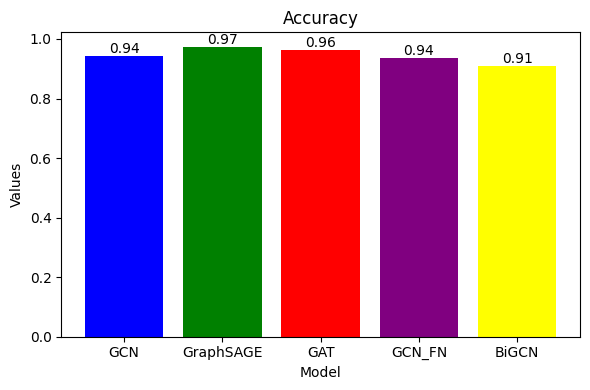

In [30]:
import matplotlib.pyplot as plt

# Dữ liệu
categories = ['GCN', 'GraphSAGE','GAT', 'GCN_FN', 'BiGCN']
values = [acc_GCN, acc_GraphSAGE, acc_GAT, acc_GCN_FN, acc_BiGCN]

plt.figure(figsize=(6, 4))
plt.bar(categories, values, color=['blue', 'green', 'red','purple', 'yellow','pink'])
plt.xlabel('Model')
plt.ylabel('Values')
plt.title('Accuracy')

# Hiển thị giá trị trên cột
for i in range(len(categories)):
     plt.text(i, values[i], '{:.2f}'.format(values[i]), ha='center', va='bottom')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

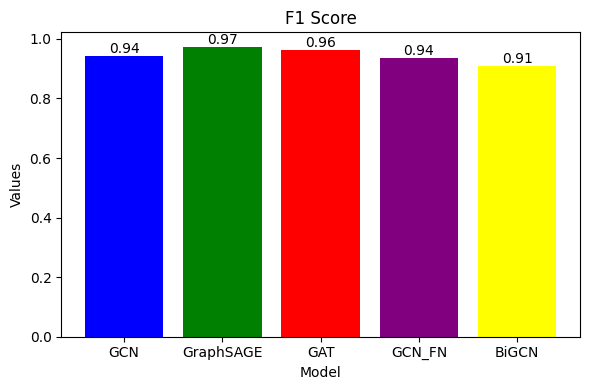

In [32]:
# Dữ liệu
categories = ['GCN', 'GraphSAGE','GAT', 'GCN_FN', 'BiGCN']
values = [f1_GCN, f1_GraphSAGE, f1_GAT, f1_GCN_FN, f1_BiGCN]

plt.figure(figsize=(6, 4))
plt.bar(categories, values, color=['blue', 'green', 'red','purple', 'yellow', 'pink'])
plt.xlabel('Model')
plt.ylabel('Values')
plt.title('F1 Score')

# Hiển thị giá trị trên cột
for i in range(len(categories)):
     plt.text(i, values[i], '{:.2f}'.format(values[i]), ha='center', va='bottom')

plt.tight_layout()
plt.show()